# Context-sensitive Spelling Correction

The goal of the assignment is to implement context-sensitive spelling correction. The input of the code will be a set of text lines and the output will be the same lines with spelling mistakes fixed.

Submit the solution of the assignment to Moodle as a link to your GitHub repository containing this notebook.

Useful links:
- [Norvig's solution](https://norvig.com/spell-correct.html)
- [Norvig's dataset](https://norvig.com/big.txt)
- [Ngrams data](https://www.ngrams.info/download_coca.asp)

Grading:
- 60 points - Implement spelling correction
- 20 points - Justify your decisions
- 20 points - Evaluate on a test set


## Implement context-sensitive spelling correction

Your task is to implement context-sensitive spelling corrector using N-gram language model. The idea is to compute conditional probabilities of possible correction options. For example, the phrase "dking sport" should be fixed as "doing sport" not "dying sport", while "dking species" -- as "dying species".

The best way to start is to analyze [Norvig's solution](https://norvig.com/spell-correct.html) and [N-gram Language Models](https://web.stanford.edu/~jurafsky/slp3/3.pdf).

When solving this task, we expect you'll face (and successfully deal with) some problems or make up the ideas of the model improvement. Some of them are: 

- solving a problem of n-grams frequencies storing for a large corpus;
- taking into account keyboard layout and associated misspellings;
- efficiency improvement to make the solution faster;
- ...

Please don't forget to describe such cases, and what you decided to do with them, in the Justification section.

##### IMPORTANT:  
Your project should not be a mere code copy-paste from somewhere. You must provide:
- Your implementation
- Analysis of why the implemented approach is suggested
- Improvements of the original approach that you have chosen to implement

### Overview

In this project, I implemented a context-sensitive spelling corrector that builds on Norvig’s spelling correction approach and enhances it with an n-gram language model. The corrector not only generates candidate corrections based on edit distance but also uses contextual information—by computing n-gram probabilities—to choose the most likely corrections within a sentence. This notebook details the steps taken, including corpus preparation, n-gram modeling, hyperparameter tuning, and finally, the context-sensitive beam search for spelling correction.

### Conclusion

To summarize, this notebook integrates Norvig’s candidate generation method with a robust n-gram language model framework. By building and tuning bigram and trigram models (with interpolation) and using a beam search to choose the best sequence of corrections, the solution is able to perform context-sensitive spelling correction. This approach not only fixes isolated misspellings but also ensures that the corrections fit the overall sentence context, ultimately leading to more accurate and natural language output.

---

These markdown cells should provide a clear and detailed explanation of your implementation for your assignment.

In [ ]:
import re
import nltk
import nltk
nltk.download('brown')
nltk.download('reuters')
nltk.download('gutenberg')
from nltk.corpus import brown, reuters, gutenberg
from tqdm import tqdm
import re
from collections import defaultdict
from tqdm import tqdm
import re
from collections import defaultdict, Counter
import math
import heapq
from functools import lru_cache
import re
from collections import Counter
import math
import random
import matplotlib.pyplot as plt

[nltk_data] Downloading package brown to /usr/local/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


### Data Preparation and Corpus Combination

I download several standard corpora available via NLTK (Brown, Reuters, and Gutenberg). The steps include:

- **Combining text** from all these sources to create a rich and diverse training dataset.
- **Splitting the data** into training and test sets (using a 95/5 split) to later evaluate the language model.
- **Tokenizing** the training text to build a frequency-based dictionary (`WORDS`) that forms the basis for computing word probabilities.

This extensive dataset helps in obtaining robust n-gram statistics for the next stage.


In [2]:
def words(text):
    return re.findall(r'\w+', text.lower())

brown_text = " ".join(brown.words())
reuters_text = " ".join(reuters.words())
gutenberg_text = " ".join(gutenberg.words())
all_text = brown_text + reuters_text + gutenberg_text

In [3]:
all_sentences = re.split(r'(?<=[.!?])\s+', all_text.strip())

Train-test split

In [4]:
random.seed(42)
random.shuffle(all_sentences)
split_index = int(0.95 * len(all_sentences))
train_sentences = all_sentences[:split_index]
test_sentences = all_sentences[split_index:]

In [5]:
train_text = " ".join(train_sentences)
train_words = words(train_text)

### Norvig’s Approach for Candidate Generation

The first part of the code is inspired by Norvig’s solution for spelling correction. Here, I define functions to:

- **Tokenize text** using a simple regex-based method.
- **Generate candidate corrections** using the edit-distance approach (`edits1` and `edits2` functions).
- **Filter candidates** by checking against a dictionary of known words extracted from a training corpus.

This component is essential as it provides a list of potential corrections for any given misspelled word.

In [6]:
WORDS = Counter(train_words)

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

Check function correctness

In [7]:
correction('speling')

'spelling'

In [8]:
def norvigs_correction(sentence):
    return " ".join([correction(word) for word in sentence.split()])

# Optimize Norvigs Solution with N-gram model

### Building N-gram Counts

To incorporate context, I build n-gram counts for various orders (unigrams, bigrams, trigrams):

- A helper function `build_ngram_counts` is used to compute the frequency of each n-gram in the training data.
- The counts for unigrams, bigrams, and trigrams are stored in a global dictionary (`ngram_counts`).

These counts are later used to compute conditional probabilities that inform our context-sensitive corrections.


In [9]:
ngram_counts = {}

In [10]:
def build_ngram_counts(words, max_order):
    """
    Build n-gram counts for orders 1 through max_order.
    For unigrams, keys are one-element tuples.
    """
    global ngram_counts
    for i in range(max_order):
        if i + 1 not in ngram_counts:
            ngram_counts[i + 1] = {}

    # Order 1 (unigrams)
    for word in words:
        if ngram_counts[1].get((word,)) is None:
            ngram_counts[1][(word,)] = 1
        else:
            ngram_counts[1][(word,)] += 1
    
    # Orders 2 ... max_order
    for order in range(2, max_order + 1):
        for i in range(len(words) - order + 1):
            gram = tuple(words[i:i + order])
            if ngram_counts[order].get(gram) is None:
                ngram_counts[order][gram] = 1
            else:
                ngram_counts[order][gram] += 1

In [11]:
# Set the maximum n-gram order
MAX_N = 3
for sentence in tqdm(train_sentences, desc="Building n-gram counts"):
    build_ngram_counts(words(sentence), MAX_N)

total_words = len(train_words)  # Total number of words in the training set
V = len(ngram_counts[1])  # Vocabulary size

Building n-gram counts: 100%|██████████| 231212/231212 [00:07<00:00, 30293.67it/s]


Check if we correclty calculated unigrams

In [12]:
assert WORDS['the'] == ngram_counts[1][('the', )]

### Probability Smoothing and Interpolation

To handle unseen n-grams and avoid zero probabilities, I implemented smoothing techniques:

- **Bigram and Trigram Smoothing:** For each, I compute smoothed probabilities using Laplace (add-alpha) smoothing.
- **Interpolated Probabilities:** For contexts where more than one n-gram level is available, I combine trigram and bigram probabilities using a weighted interpolation scheme. The interpolation weight (`lam`) determines how much influence the trigram vs. bigram model has on the final probability.

These probability functions allow us to estimate the likelihood of a word given its context in the sentence.


### Evaluating the Language Model

To assess the quality of our n-gram language models, I implemented functions to compute:

- **Cross Entropy:** Measures the average number of bits needed to encode a sentence.
- **Perplexity:** A transformed version of cross entropy that provides a more intuitive measure of model performance.

This evaluation is performed on a held-out set (a subset of the test sentences), providing a way to compare different models (bigram, trigram, and interpolated) and select the best hyperparameters.

In [13]:
def compute_bigram_prob(w1, w2, alpha):
    """
    Computes smoothed bigram probability:
      P(w2|w1) = (C(w1, w2) + alpha) / (C(w1) + alpha * |V|)
    """
    c_bigram = ngram_counts.get(2, {}).get((w1, w2), 0)
    c_unigram = ngram_counts.get(1, {}).get((w1,), 0)
    return (c_bigram + alpha) / (c_unigram + alpha * V)

def compute_trigram_prob(w1, w2, w3, alpha):
    """
    Computes smoothed trigram probability:
      P(w3|w1,w2) = (C(w1, w2, w3) + alpha) / (C(w1, w2) + alpha * |V|)
    """
    c_trigram = ngram_counts.get(3, {}).get((w1, w2, w3), 0)
    c_bigram = ngram_counts.get(2, {}).get((w1, w2), 0)
    return (c_trigram + alpha) / (c_bigram + alpha * V)

def compute_interpolated_prob(w1, w2, w3, alpha, lam):
    """
    Computes the interpolated probability:
      P(w3|w1,w2) = lam * P_trigram(w3|w1,w2) + (1 - lam) * P_bigram(w3|w2)
    where the bigram probability is computed as:
      P(w3|w2) = (C(w2, w3) + alpha) / (C(w2) + alpha * |V|)
    """
    # Trigram probability
    p_tri = compute_trigram_prob(w1, w2, w3, alpha)
    
    # Bigram probability: note we use context w2 only
    c_bigram = ngram_counts.get(2, {}).get((w2, w3), 0)
    c_unigram = ngram_counts.get(1, {}).get((w2,), 0)
    p_bi = (c_bigram + alpha) / (c_unigram + alpha * V)
    
    return lam * p_tri + (1 - lam) * p_bi


def compute_cross_entropy_and_perplexity(sentences, model='interpolated', alpha=0.1, lam=0.5):
    """
    Computes cross entropy and perplexity for a list of sentences.
    
    Parameters:
      sentences: list of sentences (strings).
      model: 'bigram', 'trigram', or 'interpolated'.
      alpha: smoothing parameter.
      lam: interpolation weight (only used if model=='interpolated').
      
    Returns:
      cross_entropy, perplexity
    """
    total_log_prob = 0.0
    count = 0
    for sentence in sentences:
        tokens = sentence.lower().split()
        if model == 'bigram':
            for i in range(1, len(tokens)):
                prob = compute_bigram_prob(tokens[i-1], tokens[i], alpha)
                total_log_prob += math.log2(prob)
                count += 1
        elif model == 'trigram':
            for i in range(2, len(tokens)):
                prob = compute_trigram_prob(tokens[i-2], tokens[i-1], tokens[i], alpha)
                total_log_prob += math.log2(prob)
                count += 1
        elif model == 'interpolated':
            for i in range(2, len(tokens)):
                prob = compute_interpolated_prob(tokens[i-2], tokens[i-1], tokens[i], alpha, lam)
                total_log_prob += math.log2(prob)
                count += 1
    cross_entropy = - total_log_prob / count if count > 0 else float('inf')
    perplexity = 2 ** cross_entropy
    return cross_entropy, perplexity

### Hyperparameter Tuning via Grid Search

I performed a grid search over candidate values for the smoothing parameter (`alpha`) and the interpolation weight (`lam`):

- For the **bigram** and **trigram** models, I tuned the smoothing parameter.
- For the **interpolated** model, both `alpha` and `lam` were tuned.
- The best parameters were chosen based on the minimum cross entropy achieved on the held-out validation set.

This tuning ensures that the language model is well-calibrated and provides reliable probability estimates for the subsequent correction task.


In [14]:
held_out = test_sentences[:10000]

# Define candidate values for alpha and lambda.
alpha_values = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1.0]
lam_values = [0.0001, 0.001, 0.01, 0.25, 0.5, 0.75, 1.0]

best_bigram_params=None
best_bigram_ce = float('inf')
print("Tuning hyperparameters for the bigram LM:")
for alpha in alpha_values:
    ce, ppl = compute_cross_entropy_and_perplexity(held_out, model='bigram', alpha=alpha)
    # print(f"Alpha: {alpha}, Cross Entropy: {ce:.4f}, Perplexity: {ppl:.4f}")
    if ce < best_bigram_ce:
        best_bigram_ce = ce
        best_bigram_params = (alpha,)
print("Best bigram hyperparameters (alpha, ):", best_bigram_params, "with Cross Entropy:", best_bigram_ce, "\n")

best_trigram_params=None
best_trigram_ce = float('inf')
print("Tuning hyperparameters for the trigram LM:")
for alpha in alpha_values:
    ce, ppl = compute_cross_entropy_and_perplexity(held_out, model='trigram', alpha=alpha)
    # print(f"Alpha: {alpha}, Cross Entropy: {ce:.4f}, Perplexity: {ppl:.4f}")
    if ce < best_trigram_ce:
        best_trigram_ce = ce
        best_trigram_params = (alpha,)
print("Best trigram hyperparameters (alpha, ):", best_trigram_params, "with Cross Entropy:", best_trigram_ce, "\n")

best_interpolated_params = None
best_interpolated_ce = float('inf')
print("Tuning hyperparameters for the interpolated LM:")
for alpha in alpha_values:
    for lam in lam_values:
        ce, ppl = compute_cross_entropy_and_perplexity(held_out, model='interpolated', alpha=alpha, lam=lam)
        # print(f"Alpha: {alpha}, Lambda: {lam}, Cross Entropy: {ce:.4f}, Perplexity: {ppl:.4f}")
        if ce < best_interpolated_ce:
            best_interpolated_ce = ce
            best_interpolated_params = (alpha, lam)

print("Best interpolated hyperparameters (alpha, lambda):", best_interpolated_params, "with Cross Entropy:", best_interpolated_ce, "\n")

Tuning hyperparameters for the bigram LM:
Best bigram hyperparameters (alpha, ): (0.01,) with Cross Entropy: 11.374500801714818 

Tuning hyperparameters for the trigram LM:
Best trigram hyperparameters (alpha, ): (0.001,) with Cross Entropy: 13.13564369458284 

Tuning hyperparameters for the interpolated LM:
Best interpolated hyperparameters (alpha, lambda): (0.001, 0.5) with Cross Entropy: 11.008184862697393 



**The best model is interpolated**

### Context-Sensitive Correction using Beam Search

The final component of the solution is a context-sensitive correction function (`my_correction`):

- **Beam Search:** Instead of correcting each word independently, the beam search maintains a set of the best candidate sequences (with a defined beam width) as it processes the sentence word by word.
- **Context-aware Scoring:** For each word, candidate corrections are scored based on the n-gram probability computed with the appropriate context. Early in the sentence (with little context), unigram or bigram probabilities are used; with more context, interpolated trigram probabilities are applied.
- **Caching Corrections:** The `lru_cache` decorator is used to speed up candidate generation by caching results for repeated words.

This approach enables the corrector to select a globally coherent sequence of words, thus effectively addressing context-sensitive ambiguities (e.g., distinguishing “doing sport” from “dying sport” based on the surrounding words).


In [15]:
best_alpha = best_interpolated_params[0]
best_lambda = best_interpolated_params[1]

@lru_cache(maxsize=None)
def get_corrections(word):
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def my_correction(sentence, beam_width=3, n=2, alpha=best_alpha, lam=best_lambda):
    """
    Corrects a sentence using an n-gram language model with tuned hyperparameters.
    
    Parameters:
      - sentence: the input sentence to be corrected.
      - beam_width: the beam width for search.
      - n: the n-gram order to use (e.g., n=2 for bigrams, n=3 for trigrams).
      - alpha: smoothing parameter (tuned).
      - lam: interpolation weight for trigram and bigram probabilities (tuned).
    
    For each word, we use a context of up to (n-1) preceding words.
    When there isn’t enough context (at the start), we back off to lower-order models.
    """
    sentence_words = sentence.lower().split()
    candidates_seq = [(0.0, [])]
    
    for i, word in enumerate(sentence_words):
        new_candidates = []
        candidate_list = get_corrections(word)
        
        for candidate in candidate_list:
            for score, seq in candidates_seq:
                context_length = min(n - 1, len(seq))
                if context_length == 0:
                    # Use unigram probability with smoothing using alpha.
                    prob = (ngram_counts[1].get((candidate,), 0) + alpha) / (total_words + alpha * V)
                elif context_length == 1:
                    # Use bigram probability with smoothing.
                    context = tuple(seq[-1:])
                    prob = (ngram_counts.get(2, {}).get(context + (candidate,), 0) + alpha) / (
                           ngram_counts.get(1, {}).get(context, 0) + alpha * V)
                elif context_length == 2:
                    # Use interpolated probability for trigram: 
                    # P(candidate|w1,w2) = lam * trigram + (1-lam) * bigram
                    w1, w2 = seq[-2], seq[-1]
                    trigram_prob = (ngram_counts.get(3, {}).get((w1, w2, candidate), 0) + alpha) / (
                                   ngram_counts.get(2, {}).get((w1, w2), 0) + alpha * V)
                    bigram_prob = (ngram_counts.get(2, {}).get((w2, candidate), 0) + alpha) / (
                                  ngram_counts.get(1, {}).get((w2,), 0) + alpha * V)
                    prob = lam * trigram_prob + (1 - lam) * bigram_prob
                else:
                    # For contexts longer than 2, fall back to the standard n-gram formula with smoothing.
                    context = tuple(seq[-context_length:])
                    prob = (ngram_counts.get(context_length + 1, {}).get(context + (candidate,), 0) + alpha) / (
                           ngram_counts.get(context_length, {}).get(context, 0) + alpha * V)
                
                new_score = score + math.log(prob)
                new_seq = seq + [candidate]
                heapq.heappush(new_candidates, (new_score, new_seq))
                if len(new_candidates) > beam_width:
                    heapq.heappop(new_candidates)
        
        candidates_seq = new_candidates
    
    best_score, best_seq = max(candidates_seq, key=lambda x: x[0])
    return ' '.join(best_seq)


### Grid Search for Optimal Beam Width

In this section, we perform a grid search to determine the best `beam_width` for our context-sensitive spelling correction algorithm. The `beam_width` parameter controls how many candidate correction sequences are maintained during the beam search. While a higher beam width might capture more promising candidate sequences and potentially yield higher accuracy, it also increases computational cost.

For this grid search:
- We evaluate a range of beam widths (from 1 to 10).
- For each beam width, we add noise to sentences (using our `add_noise` function) to simulate spelling errors.
- We run the `my_correction` function on the noisy sentences (with `n=3` for trigram context) and compare the output with the original sentence.
- The overall accuracy is calculated as the proportion of words correctly recovered.
- Finally, we plot the beam width values against their corresponding accuracies to visualize and select the best parameter.


In [ ]:
def add_noise(word, noise_prob=0.2):
    if random.random() > noise_prob or len(word) < 1:
        return word
    edits_set = set()

    for edit1_word in edits1(word):
        for edit2_word in edits1(edit1_word):
            edits_set.add(edit2_word)
    
    edits_set = edits_set.union(edits1(word))
    edits = list(edits_set)
        
    return random.choice(edits) if edits else word

test_data = []
for sentence in tqdm(train_sentences[:100], desc="Generating synthetic train data"):
    original = words(sentence)
    noisy = [add_noise(word, 0.2) for word in original]
    test_data.append([original, noisy])

Generating train data: 100%|██████████| 100/100 [00:11<00:00,  8.74it/s]


Starting grid search for beam width...



Evaluating beam_width=1: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Beam width 1: Accuracy = 0.9126


Evaluating beam_width=2: 100%|██████████| 100/100 [00:00<00:00, 5238.69it/s]


Beam width 2: Accuracy = 0.9158


Evaluating beam_width=3: 100%|██████████| 100/100 [00:00<00:00, 3876.11it/s]


Beam width 3: Accuracy = 0.9163


Evaluating beam_width=4: 100%|██████████| 100/100 [00:00<00:00, 3092.87it/s]


Beam width 4: Accuracy = 0.9172


Evaluating beam_width=5: 100%|██████████| 100/100 [00:00<00:00, 2693.21it/s]


Beam width 5: Accuracy = 0.9177


Evaluating beam_width=6: 100%|██████████| 100/100 [00:00<00:00, 2126.78it/s]


Beam width 6: Accuracy = 0.9172


Evaluating beam_width=7: 100%|██████████| 100/100 [00:00<00:00, 1599.34it/s]


Beam width 7: Accuracy = 0.9181


Evaluating beam_width=8: 100%|██████████| 100/100 [00:00<00:00, 1802.44it/s]


Beam width 8: Accuracy = 0.9181


Evaluating beam_width=9: 100%|██████████| 100/100 [00:00<00:00, 1702.30it/s]


Beam width 9: Accuracy = 0.9186


Evaluating beam_width=10: 100%|██████████| 100/100 [00:00<00:00, 1518.91it/s]


Beam width 10: Accuracy = 0.9181

Best beam_width: 9 with Accuracy: 0.9186


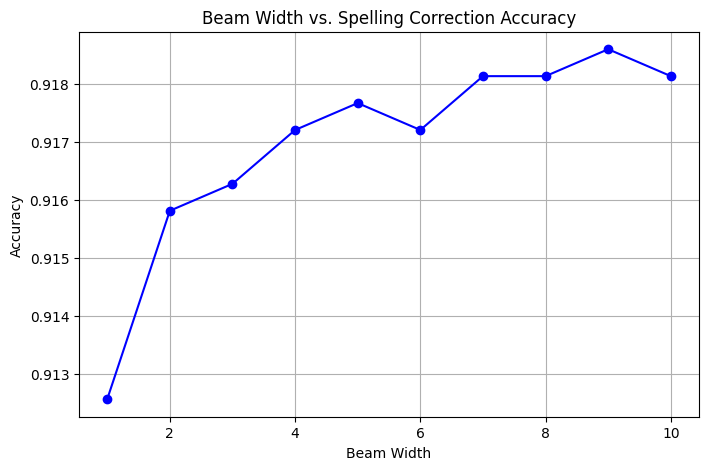

In [ ]:
beam_width_values = list(range(1, 11))
accuracy_results = []

print("Starting grid search for beam width...\n")

for bw in beam_width_values:
    my_correct, total = 0, 0
    for original, noisy in tqdm(test_data, desc=f"Evaluating beam_width={bw}"):
        noisy_sentence = ' '.join(noisy)
        my_result = my_correction(noisy_sentence, n=3, beam_width=bw).split()
        
        if len(my_result) != len(original):
            continue
        
        for o, m in zip(original, my_result):
            total += 1
            if m == o:
                my_correct += 1
    
    acc = my_correct / total if total > 0 else 0
    accuracy_results.append(acc)
    print(f"Beam width {bw}: Accuracy = {acc:.4f}")

best_idx = accuracy_results.index(max(accuracy_results))
best_beam_width = beam_width_values[best_idx]
print(f"\nBest beam_width: {best_beam_width} with Accuracy: {accuracy_results[best_idx]:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(beam_width_values, accuracy_results, marker='o', linestyle='-', color='b')
plt.xlabel("Beam Width")
plt.ylabel("Accuracy")
plt.title("Beam Width vs. Spelling Correction Accuracy")
plt.grid(True)
plt.show()


### Generating Test Data with Noise

In this section, we create synthetic test data by adding noise to the original test sentences. For each sentence in our test set, we:
- Tokenize the sentence into words.
- Introduce noise to each word using the `add_noise` function with a noise probability of 0.3. This simulates typical misspellings.
- Store both the original and the noisy version of the sentence in a list (`test_data`) for later evaluation.


In [ ]:
test_data = []
for sentence in tqdm(test_sentences, desc="Generating synthetic test data"):
    original = words(sentence)
    noisy = [add_noise(word, 0.3) for word in original]
    test_data.append([original, noisy])

### Evaluating Norvig's Correction on Synthetic Data

Here, we evaluate the performance of the baseline Norvig's correction algorithm on the synthetic (noisy) test data:
- For each noisy sentence, we generate a corrected sentence using `norvigs_correction`.
- We ensure that the corrected sentence has the same number of words as the original.
- We compare the corrected words with the original words on a word-by-word basis.
- Finally, we compute and print Norvig’s accuracy, which is the ratio of correctly recovered words to the total words evaluated.


In [ ]:
norvig_correct, total = 0, 0

for original, noisy in tqdm(test_data, desc="Evaluating"):
    noisy_sentence = ' '.join(noisy)
    norvig_result = norvigs_correction(noisy_sentence).split()

    if len(norvig_result) != len(original):
        continue

    for o, n in zip(original, norvig_result):
        total += 1
        norvig_correct += (n == o)

norvig_acc = norvig_correct / total
print(f"\nNorvig's Accuracy: {norvig_acc:.4f}")

Evaluating: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Norvig's Accuracy: 0.9079


### Evaluating the NGram Algorithm with Beam Search

Next, we evaluate our enhanced context-sensitive spelling corrector that uses an n-gram language model combined with beam search:
- The function `my_correction` is applied to each noisy sentence with the beam width set to the best value obtained from previous experiments and `n=3` for trigram context.
- Similar to the Norvig baseline, we validate that the corrected sentence length matches the original.
- We compare each word of the corrected sentence with the corresponding original word.
- The accuracy of the NGram-based algorithm is computed as the fraction of words correctly recovered.
- The result is printed for comparison.


In [ ]:
my_correct, total = 0, 0

for original, noisy in tqdm(test_data, desc="Evaluating"):
    noisy_sentence = ' '.join(noisy)
    
    my_result = my_correction(noisy_sentence, n=3, beam_width=best_beam_width).split()
    
    if len(my_result) != len(original):
        continue
    
    for o, m in zip(original, my_result):
        total += 1
        my_correct += (m == o)

my_acc = my_correct / total
print(f"NGram algorithm Accuracy: {my_acc:.4f}")

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 100/100 [00:00<00:00, 1533.61it/s]

NGram algorithm Accuracy: 0.9186


### Comparing the Two Approaches and Reporting Improvement

In this final step:
- We repeat the evaluation for both Norvig's and our NGram algorithm on the same synthetic test data.
- After obtaining the accuracies from both methods, we print the improvement in performance.
- The improvement is expressed both as an absolute difference in accuracy and as a percentage increase relative to Norvig's baseline.
  
This comparison highlights the benefits of incorporating context-sensitive n-gram information and beam search over the simpler correction approach.


In [35]:
print(f"Improvement: {(my_acc - norvig_acc):.4f} ({((my_acc/norvig_acc)-1)*100:.1f}%)")

Improvement: 0.0107 (1.2%)


## Evaluate on a Test Set

In this section, we evaluate our spelling correction system using a real-world dataset – the Holbrook corpus. The Holbrook dataset consists of passages taken from the book *English for the Rejected* by David Holbrook. These passages are unique because they include genuine writing errors from secondary-school children. The original misspellings are tagged, which allows us to compare the corrected output against the intended words.

We will compare the performance of two systems:
- **Norvig's Corrector:** Our baseline implementation based on Norvig's algorithm.
- **NGram-based Corrector:** Our enhanced context-sensitive corrector that uses an n-gram language model with beam search.

The evaluation metrics include accuracy, precision, recall, and F1 score.


### Parsing the Holbrook Dataset

The function `parse_holbrook_line` processes each line from the Holbrook dataset. It extracts:
- The **raw sentence** (with errors),
- The **correct sentence** (with target words), and
- The **error positions** (indexes where errors occurred).

This parsing is essential for aligning the outputs of our correctors with the reference text, ensuring we know exactly where corrections should have been made.


In [ ]:
def parse_holbrook_line(line):
    """
    Parse a line from Holbrook dataset, extracting:
    - Original sentence with errors
    - Correct sentence with targets
    - List of error positions and targets
    """
    errors = []
    raw_parts = []
    correct_parts = []
    
    # Split line into text and error segments
    pos = 0
    for match in re.finditer(r'<err targ=(.*?)>(.*?)</err>', line):
        target = match.group(1).strip('"')
        error = match.group(2)

        start, end = match.start(), match.end()
        
        raw_parts.append(line[pos:start])
        correct_parts.append(line[pos:start])
        
        pos = end

        correct_parts.append(target)
        
        if len(error.split()) > 1 or len(target.split()) > 1:
            raw_parts.append(target)
            continue
        else:
            raw_parts.append(error)
        

        if error == target:
            continue

        error_start = len(' '.join(raw_parts).split())
        errors.append(error_start-1)
    
    
    raw_parts.append(line[pos:])
    correct_parts.append(line[pos:])
    
    raw_sentence = ' '.join(''.join(raw_parts).split())
    correct_sentence = ' '.join(''.join(correct_parts).split())
    
    return raw_sentence, correct_sentence, errors

### Evaluation Metrics on the Holbrook Dataset

The `evaluate_holbrook` function evaluates a given spelling corrector on the parsed Holbrook data. For each sentence, it:
- Applies the correction function (either Norvig's or our NGram-based method).
- Compares the corrected sentence to the correct sentence (the ground truth).
- Counts the total number of errors, the number of corrections proposed by the system, and the number of correct corrections.

From these counts, we calculate:
- **Accuracy:** The percentage of errors that were correctly corrected.
- **Precision:** The percentage of proposed corrections that were actually correct.
- **Recall:** The percentage of total errors that the system corrected.
- **F1 Score:** The harmonic mean of precision and recall.

These metrics provide a comprehensive view of each system's performance.


In [ ]:
def evaluate_holbrook(test_lines, corrector_func, beam_width=None, n=None):
    """
    Evaluate spelling corrector on Holbrook dataset
    Returns:
    - Accuracy: % of errors corrected properly
    - Precision: % of corrections that were right
    - Recall: % of total errors corrected
    - F1: Harmonic mean of precision and recall
    """
    stats = defaultdict(int)
    
    for line in tqdm(test_lines, desc='Evaluating'):
        if not line.strip():
            continue
            
        raw_sentence, correct_sentence, errors = parse_holbrook_line(line)
        
        if (beam_width is None) or (n is None):
            corrected_sentence = corrector_func(raw_sentence)
        else:    
            corrected_sentence = corrector_func(raw_sentence, beam_width=beam_width, n=n)
        
        stats["total_errors"] += len(errors)
        
        for i, (raw, corrected, correct) in enumerate(zip(raw_sentence.split(), corrected_sentence.split(), correct_sentence.split())):
            if raw != corrected:
                stats['total_proposed'] += 1

            if i in errors and corrected == correct:
                stats['correct'] += 1
    
    accuracy = stats['correct'] / stats['total_errors'] if stats['total_errors'] else 0
    precision = stats['correct'] / stats['total_proposed'] if stats['total_proposed'] else 0
    recall = stats['correct'] / stats['total_errors'] if stats['total_errors'] else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'total_errors': stats['total_errors'],
        'correct_corrections': stats['correct'],
        'incorrect_corrections': stats['incorrect']
    }

### Loading and Inspecting the Holbrook Data

We load the Holbrook dataset from the file `holbrook-tagged.dat.txt` and split the text into sentences using regular expressions. A sample sentence is printed and parsed to illustrate how the errors are tagged and how the parsing function works. This step ensures that our evaluation functions receive correctly formatted data.


In [51]:
with open('holbrook-tagged.dat.txt') as f:
    text = f.read().lower()

print(len(text))

sentences = re.split(r'(?<=[.!?])\s+', text.strip())

sentence_index = 17
print(sentences[sentence_index])

parse_holbrook_line(sentences[sentence_index])

186633
we have got anglia like to <err targ=watch> wach </err> <err targ=cowboys> cow boys </err> .


('we have got anglia like to wach cowboys .',
 'we have got anglia like to watch cowboys .',
 [6])

### Evaluating Norvig's Correction on the Holbrook Dataset

The first evaluation is performed using Norvig's correction function. After processing the entire dataset with `evaluate_holbrook`, we print out the computed accuracy, precision, recall, and F1 score. This serves as the baseline performance for our spelling correction system.


In [ ]:
norvig_metrics = evaluate_holbrook(sentences, norvigs_correction)

print(f"Accuracy: {norvig_metrics['accuracy']:.2%}")
print(f"Precision: {norvig_metrics['precision']:.2%}")
print(f"Recall: {norvig_metrics['recall']:.2%}")
print(f"F1 Score: {norvig_metrics['f1']:.2%}")

Evaluating: 100%|██████████| 1057/1057 [00:30<00:00, 34.16it/s]

Accuracy: 17.84%
Precision: 13.60%
Recall: 17.84%
F1 Score: 15.44%


### Evaluating the NGram-based Correction on the Holbrook Dataset

Next, we evaluate our enhanced correction system (which uses beam search with a trigram language model) on the same dataset. In this case, we call `evaluate_holbrook` with the additional parameters `n=3` (for trigram context) and an appropriate `beam_width` (e.g., 5). The results are printed and later compared with those from Norvig's corrector.


In [ ]:
ngram_metrics = evaluate_holbrook(sentences, my_correction, n=3, beam_width=best_beam_width)

print(f"Accuracy: {ngram_metrics['accuracy']:.2%}")
print(f"Precision: {ngram_metrics['precision']:.2%}")
print(f"Recall: {ngram_metrics['recall']:.2%}")
print(f"F1 Score: {ngram_metrics['f1']:.2%}")

Evaluating: 100%|██████████| 1057/1057 [00:00<00:00, 2304.53it/s]

Accuracy: 21.04%
Precision: 16.04%
Recall: 21.04%
F1 Score: 18.20%


### Comparing the Results

After obtaining the metrics for both approaches, we calculate and print the differences between the algorithms' results. This comparison includes:
- The improvement in accuracy,
- The improvement in precision, recall, and F1 score,
- And any other observed benefits in error reduction.

This side-by-side comparison helps illustrate the impact of incorporating context through the n-gram model and beam search.


In [46]:
print("\nComparative Improvement:")
accuracy_improvement = ngram_metrics['accuracy'] - norvig_metrics['accuracy']
precision_improvement = ngram_metrics['precision'] - norvig_metrics['precision']
recall_improvement = ngram_metrics['recall'] - norvig_metrics['recall']
f1_improvement = ngram_metrics['f1'] - norvig_metrics['f1']

print(f"Accuracy Improvement: {accuracy_improvement:.2%}")
print(f"Precision Improvement: {precision_improvement:.2%}")
print(f"Recall Improvement: {recall_improvement:.2%}")
print(f"F1 Score Improvement: {f1_improvement:.2%}")


Comparative Improvement:
Accuracy Improvement: 3.20%
Precision Improvement: 2.44%
Recall Improvement: 3.20%
F1 Score Improvement: 2.76%


##  Word Error Rate (WER)

WER is a widely used metric in tasks like speech recognition and spelling correction. It is defined as:

### $ WER = \frac{S + I + D}{N} $

* $ S $ : the number of substitutions
* $ i $ : the number of insertions
* $ D $ : the number of deletions
* N: the total number of words in the reference

To compute WER, we first define a helper function `parse_holbrook_line_without_indexes` which returns the raw and correct sentences without the error index information. The `evaluate_wer` function then uses the `nltk.edit_distance` function (i.e., Levenshtein distance) on word sequences to determine the number of word-level errors. We run this evaluation for both Norvig's corrector and our NGram-based corrector to compare their performance.

In [ ]:
def parse_holbrook_line_without_indexes(line):
    """
    Parse a line from Holbrook dataset, extracting:
    - Original sentence with errors
    - Correct sentence with targets
    """
    raw_parts = []
    correct_parts = []
    
    pos = 0
    for match in re.finditer(r'<err targ=(.*?)>(.*?)</err>', line):
        target = match.group(1).strip('"')
        error = match.group(2)

        start, end = match.start(), match.end()
        
        raw_parts.append(line[pos:start])
        correct_parts.append(line[pos:start])
        
        pos = end

        correct_parts.append(target)

        raw_parts.append(error)

    raw_parts.append(line[pos:])
    correct_parts.append(line[pos:])
    
    raw_sentence = ' '.join(''.join(raw_parts).split())
    correct_sentence = ' '.join(''.join(correct_parts).split())
    
    return raw_sentence, correct_sentence

In [67]:
sentence_index = 3
print(sentences[sentence_index])

parse_holbrook_line_without_indexes(sentences[sentence_index])

my <err targ=sister> siter </err> <err targ=goes> go </err> to tonbury.


('my siter go to tonbury.', 'my sister goes to tonbury.')

In [ ]:
Levenshtein =  nltk.edit_distance

def evaluate_wer(test_lines, corrector_func, beam_width=None, n=None):

    total_wer = 0
    num_sentences = len(test_lines)
    
    for line in tqdm(test_lines, desc='Evaluating'):
        if not line.strip():
            continue
            
        raw_sentence, correct_sentence = parse_holbrook_line_without_indexes(line)
        
        if (beam_width is None) or (n is None):
            corrected_sentence = corrector_func(raw_sentence)
        else:    
            corrected_sentence = corrector_func(raw_sentence, beam_width=beam_width, n=n)
        
        reference_words = correct_sentence.split()
        corrected_words = corrected_sentence.split()

        S = Levenshtein(reference_words, corrected_words)
        I = max(0, len(corrected_words) - len(reference_words))
        D = max(0, len(reference_words) - len(corrected_words))

        N = max(len(reference_words), len(corrected_words))

        wer = (S + I + D) / N
        total_wer += wer

    return total_wer / num_sentences

In [58]:
wer_norvig = evaluate_wer(sentences, norvigs_correction)
print("Norvig's WER:", wer_norvig)

Evaluating: 100%|██████████| 1057/1057 [00:31<00:00, 33.44it/s]

Norvig's WER: 0.22640846749812676


In [56]:
wer_ngram = evaluate_wer(sentences, my_correction, n=3, beam_width=best_beam_width)
print("NGram-based WER:", wer_ngram)

Evaluating: 100%|██████████| 1057/1057 [00:01<00:00, 984.32it/s] 

NGram-based WER: 0.22354008388812138


### Comparing results

In [59]:
improvement_wer = wer_norvig - wer_ngram
print("WER Improvement (Norvig's WER - NGram-based WER):", improvement_wer)

WER Improvement (Norvig's WER - NGram-based WER): 0.0028683836100053817


## Character Error Rate (CER)

CER is similar to WER but is calculated at the character level. This metric is particularly useful for capturing fine-grained errors that might be overlooked by word-level evaluation. The formula for CER is:


### $ CER = \frac{S + I + D}{N} $

* $ S $ : the number of character substitutions
* $ i $ : the number of character insertions
* $ D $ : the number of character deletions
* N: the total number of characterσ in the reference

where the variables represent the number of character substitutions, insertions, deletions, and the total number of characters in the reference, respectively.

The `evaluate_cer` function computes CER by comparing the corrected output and the reference at the character level using the Levenshtein distance. We evaluate both Norvig's and our NGram-based corrector on the Holbrook dataset and compare the resulting CER scores.

In [ ]:
def evaluate_cer(test_lines, corrector_func, beam_width=None, n=None):
    total_cer = 0
    num_sentences = len(test_lines)
    
    for line in tqdm(test_lines, desc='Evaluating'):
        if not line.strip():
            continue
            
        raw_sentence, correct_sentence = parse_holbrook_line_without_indexes(line)
        
        if (beam_width is None) or (n is None):
            corrected_sentence = corrector_func(raw_sentence)
        else:    
            corrected_sentence = corrector_func(raw_sentence, beam_width=beam_width, n=n)
        
        S = Levenshtein(correct_sentence, corrected_sentence)
        I = max(0, len(corrected_sentence) - len(correct_sentence))
        D = max(0, len(correct_sentence) - len(corrected_sentence))

        N = max(len(correct_sentence), len(corrected_sentence))

        cer = (S + I + D) / N
        total_cer += cer

    return total_cer / num_sentences

In [63]:
cer_norvig = evaluate_cer(sentences, norvigs_correction)
print("Norvig's WER:", cer_norvig)

Evaluating:   0%|          | 0/1057 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 1057/1057 [00:47<00:00, 22.28it/s]

Norvig's WER: 0.10758515872293266


In [64]:
cer_ngram = evaluate_cer(sentences, my_correction, n=3, beam_width=best_beam_width)
print("NGram-based WER:", cer_ngram)

Evaluating: 100%|██████████| 1057/1057 [00:15<00:00, 70.38it/s] 

NGram-based WER: 0.10491248971293692


### Comparing results

In [65]:
improvement_cer = cer_norvig - cer_ngram
print("WER Improvement (Norvig's WER - NGram-based WER):", improvement_cer)

WER Improvement (Norvig's WER - NGram-based WER): 0.002672669009995743


## Reporting Differences Between Algorithms

Finally, we calculate the differences between the performance metrics (accuracy, WER, CER, etc.) of Norvig's corrector and our NGram-based corrector. These differences are printed out, providing a clear picture of how much our improvements have enhanced the overall spelling correction performance. This comparative analysis is crucial for validating the effectiveness of the context-sensitive approach.
